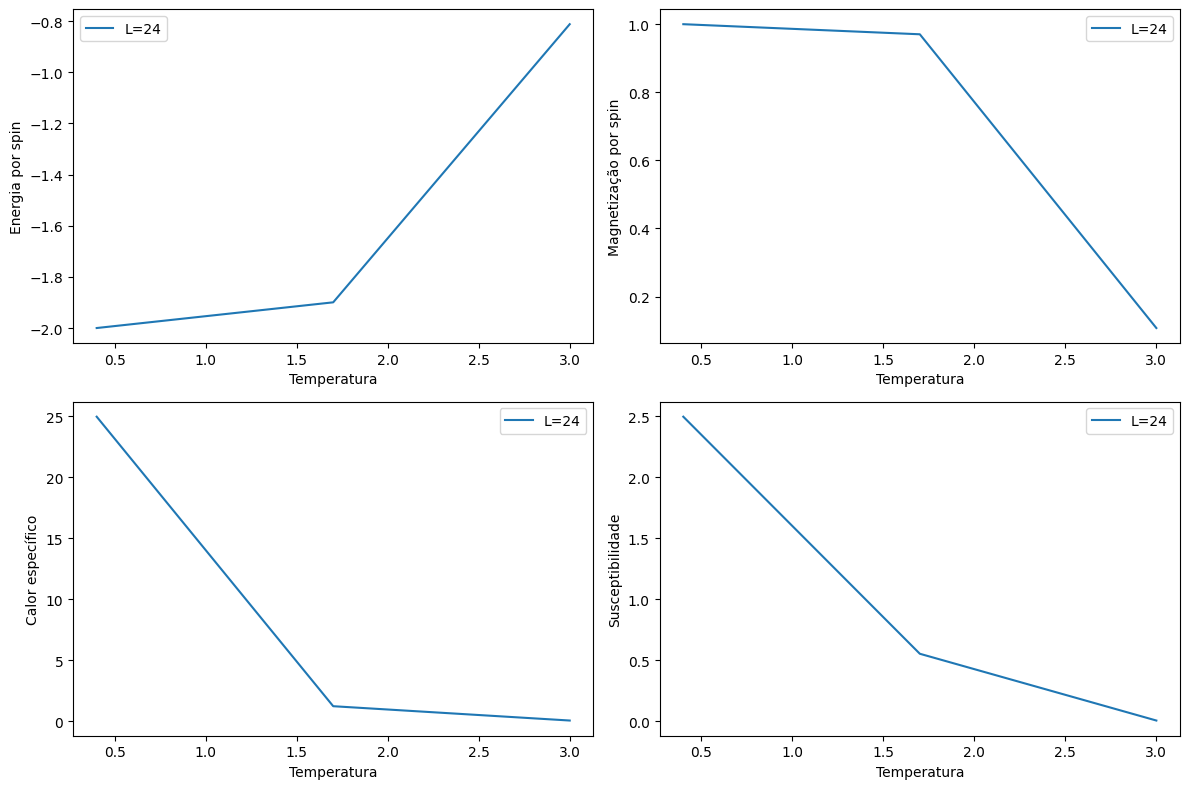

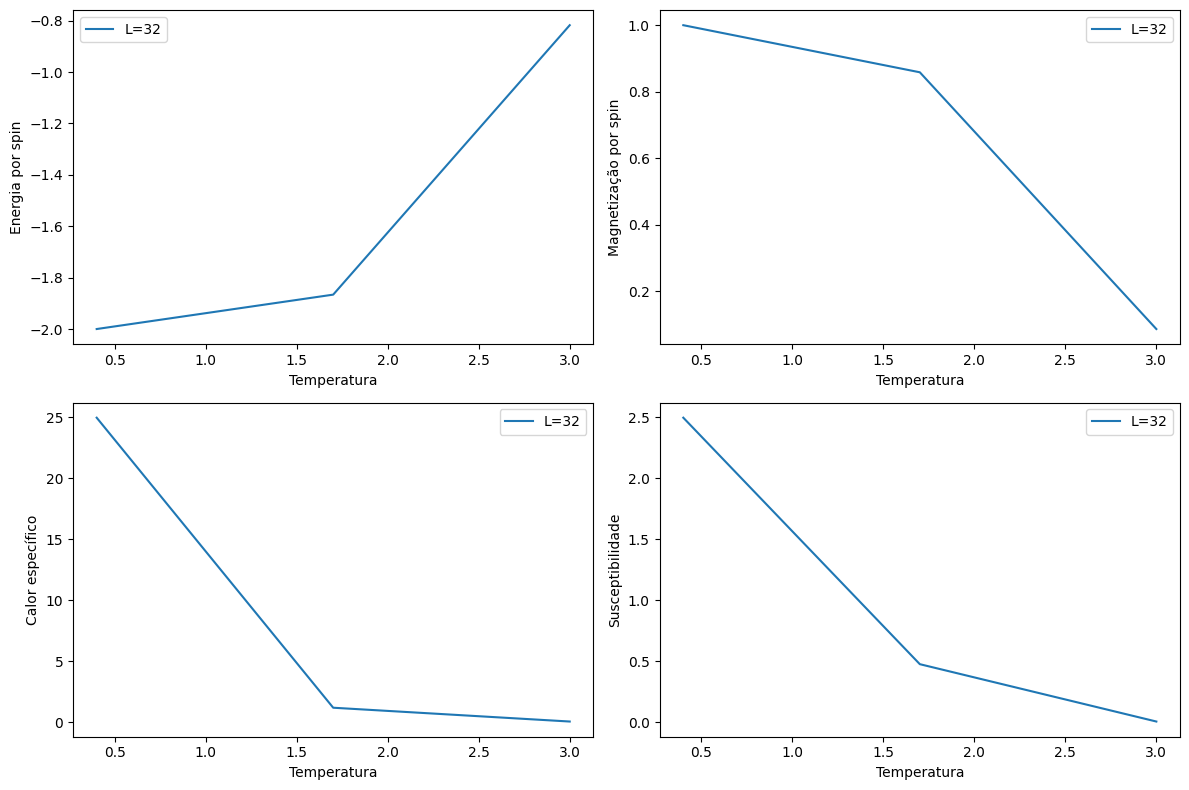

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# Funções auxiliares (já descritas anteriormente)
@jit(nopython=True)
def vizinhos(N):
    L = int(np.sqrt(N))
    viz = np.zeros((N, 4), dtype=np.int16)
    for k in range(N):
        viz[k, 0] = k + 1 if (k + 1) % L != 0 else k + 1 - L
        viz[k, 1] = k + L if k < N - L else k + L - N
        viz[k, 2] = k - 1 if k % L != 0 else k + L - 1
        viz[k, 3] = k - L if k >= L else k + N - L
    return viz

@jit(nopython=True)
def energia(s, viz):
    N = len(s)
    ener = 0
    for i in range(N):
        h = s[viz[i, 0]] + s[viz[i, 1]]
        ener -= s[i] * h
    return ener

def expos(beta):
    ex = np.zeros(5, dtype=np.float32)
    ex[0] = np.exp(8.0 * beta)
    ex[1] = np.exp(4.0 * beta)
    ex[2] = 1.0
    ex[3] = np.exp(-4.0 * beta)
    ex[4] = np.exp(-8.0 * beta)
    return ex

@jit(nopython=True)
def metropolis_step(s, viz, ex):
    N = len(s)
    for _ in range(N):
        i = np.random.randint(N)
        h = s[viz[i, 0]] + s[viz[i, 1]] + s[viz[i, 2]] + s[viz[i, 3]]
        dE = 2 * s[i] * h
        de_index = int(s[i] * h * 0.5 + 2)
        if dE <= 0 or np.random.rand() < ex[de_index]:
            s[i] = -s[i]
    return s

# Parâmetros da Simulação
L_values = [24, 32]  # Tamanhos da rede
T_range = np.linspace(0.4, 3.0, 3)  # Intervalo de temperaturas
Nterm = 1000  # Passos de termalização
NMCS = 5000  # Passos para média
num_blocks = 10  # Número de blocos para cálculo de erro

# Arrays para armazenar resultados
energia_por_spin = []
magnetizacao_por_spin = []
calor_especifico = []
susceptibilidade = []

for L in L_values:
    N = L * L
    viz = vizinhos(N)
    
    energia_L = []
    magnetizacao_L = []
    calor_especifico_L = []
    susceptibilidade_L = []

    for T in T_range:
        beta = 1.0 / T
        ex = expos(beta)
        s = np.random.choice([-1, 1], N)  # Configuração inicial aleatória
        
        # Termalização
        for _ in range(Nterm):
            s = metropolis_step(s, viz, ex)

        # Coleta de dados para NMCS passos de Monte Carlo
        energia_total, magnetizacao_total = 0, 0
        energia_sq_total, magnetizacao_sq_total = 0, 0

        for _ in range(NMCS):
            s = metropolis_step(s, viz, ex)
            E = energia(s, viz)
            M = abs(s.sum())
            
            energia_total += E
            magnetizacao_total += M
            energia_sq_total += E ** 2
            magnetizacao_sq_total += M ** 2

        # Calculando médias por spin
        energia_media = energia_total / (NMCS * N)
        magnetizacao_media = magnetizacao_total / (NMCS * N)
        energia_sq_media = energia_sq_total / (NMCS * N)
        magnetizacao_sq_media = magnetizacao_sq_total / (NMCS * N)
        
        # Calor específico e susceptibilidade
        cv = (beta ** 2 / N) * (energia_sq_media - energia_media ** 2)
        chi = (beta / N) * (magnetizacao_sq_media - magnetizacao_media ** 2)
        
        energia_L.append(energia_media)
        magnetizacao_L.append(magnetizacao_media)
        calor_especifico_L.append(cv)
        susceptibilidade_L.append(chi)

    # Armazenando os resultados para cada tamanho L
    energia_por_spin.append(energia_L)
    magnetizacao_por_spin.append(magnetizacao_L)
    calor_especifico.append(calor_especifico_L)
    susceptibilidade.append(susceptibilidade_L)

# Plotando as grandezas
for i, L in enumerate(L_values):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(T_range, energia_por_spin[i], label=f'L={L}')
    plt.xlabel('Temperatura')
    plt.ylabel('Energia por spin')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(T_range, magnetizacao_por_spin[i], label=f'L={L}')
    plt.xlabel('Temperatura')
    plt.ylabel('Magnetização por spin')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(T_range, calor_especifico[i], label=f'L={L}')
    plt.xlabel('Temperatura')
    plt.ylabel('Calor específico')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(T_range, susceptibilidade[i], label=f'L={L}')
    plt.xlabel('Temperatura')
    plt.ylabel('Susceptibilidade')
    plt.legend()

    plt.tight_layout()
    plt.show()
